In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

<Figure size 720x540 with 0 Axes>

### 데이터 준비

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

print("data shape: %r, target shape: %r" % (X.shape, y.shape))
print("classes: %r" % list(np.unique(y)))

data shape: (1797, 64), target shape: (1797,)
classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [3]:
X[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [4]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1))
        plt.imshow(data[i].reshape(shape), interpolation=interpolation)
        plt.title(labels[i])
        plt.xticks(()), plt.yticks(())

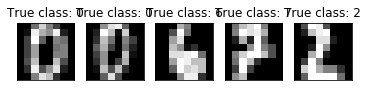

In [5]:
subsample = np.random.permutation(X.shape[0])[:5]
images = X[subsample]
labels = ['True class: %d' % l for l in y[subsample]]
plot_gallery(images, labels, shape=(8, 8))

### feature reduction

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_pca.shape

(1797, 2)

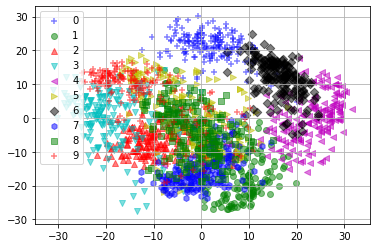

In [7]:
from itertools import cycle

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
markers = ['+', 'o', '^', 'v', '<', '>', 'D', 'h', 's']
for i, c, m in zip(np.unique(y), cycle(colors), cycle(markers)):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
        c=c, marker=m, label=i, alpha=0.5)
    
_ = plt.legend(loc='best')

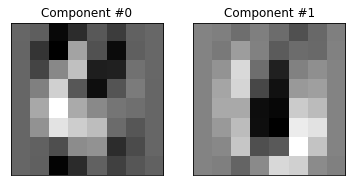

In [8]:
labels = ['Component #%d' % i for i in range(len(pca.components_))]
plot_gallery(pca.components_, labels, shape=(8, 8))

### 모델 생성 - overfit

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

from sklearn.svm import SVC
svc = SVC(kernel='rbf').fit(X_train, y_train)
train_score = svc.score(X_train, y_train) 
train_score

c:\users\iwannab1\anaconda3\envs\edu\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0

In [10]:
test_score = svc.score(X_test, y_test)
test_score

0.4866666666666667

### hyper-parameter tuning

In [11]:
svc_2 = SVC(kernel='rbf', C=100, gamma=0.001).fit(X_train, y_train)
svc_2.score(X_train, y_train)

1.0

In [12]:
svc_2.score(X_test, y_test)

0.9933333333333333

### cross validation

In [13]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)

for train_index, test_index in cv.split(X):
    svc = SVC(kernel="rbf", C=1, gamma=0.001).fit(X[train_index], y[train_index])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(X[train_index], y[train_index]), svc.score(X[test_index], y[test_index])))

train score: 0.999, test score: 0.996

train score: 0.999, test score: 0.996

train score: 0.999, test score: 0.993



In [14]:
from sklearn.model_selection import cross_val_score

svc = SVC(kernel="rbf", C=1, gamma=0.001)
cv = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)

test_scores = cross_val_score(svc, X, y, cv=cv, n_jobs=2)
test_scores

array([0.99555556, 0.99555556, 0.99333333])

### model selection

In [15]:
n_gammas = 10
n_iter = 5
cv = ShuffleSplit(n_splits=n_iter, test_size=.25, random_state=0)

train_scores = np.zeros((n_gammas, n_iter))
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(-7, -1, n_gammas)

for i, gamma in enumerate(gammas):
    for j,(train, test) in enumerate(cv.split(X)):
        clf = SVC(C=10, gamma=gamma).fit(X[train], y[train])
        train_scores[i, j] = clf.score(X[train], y[train])
        test_scores[i, j] = clf.score(X[test], y[test])

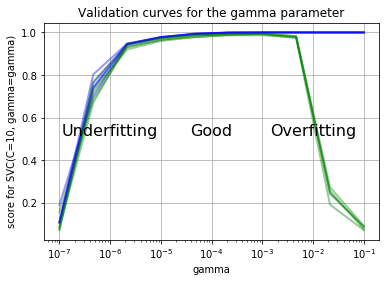

In [16]:
def plot_validation_curves(param_values, train_scores, test_scores):
    for i in range(train_scores.shape[1]):
        plt.semilogx(param_values, train_scores[:, i], alpha=0.4, lw=2, c='b')
        plt.semilogx(param_values, test_scores[:, i], alpha=0.4, lw=2, c='g')

plot_validation_curves(gammas, train_scores, test_scores)
plt.ylabel("score for SVC(C=10, gamma=gamma)")
plt.xlabel("gamma")
plt.text(1e-6, 0.5, "Underfitting", fontsize=16, ha='center', va='bottom')
plt.text(1e-4, 0.5, "Good", fontsize=16, ha='center', va='bottom')
plt.text(1e-2, 0.5, "Overfitting", fontsize=16, ha='center', va='bottom')
plt.title('Validation curves for the gamma parameter');

### validation curve

In [17]:
from sklearn.model_selection  import validation_curve

n_Cs = 10
Cs = np.logspace(-5, 5, n_Cs)

train_scores, test_scores = validation_curve(
    SVC(gamma=1e-3), X, y, 'C', Cs, cv=cv)

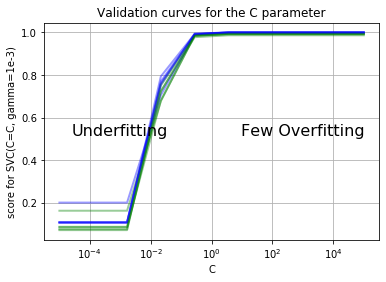

In [18]:
plot_validation_curves(Cs, train_scores, test_scores)
plt.ylabel("score for SVC(C=C, gamma=1e-3)")
plt.xlabel("C")
plt.text(1e-3, 0.5, "Underfitting", fontsize=16, ha='center', va='bottom')
plt.text(1e3, 0.5, "Few Overfitting", fontsize=16, ha='center', va='bottom')
plt.title('Validation curves for the C parameter');

### best model

In [19]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

svc_params = {
    'C': np.logspace(-1, 2, 4),
    'gamma': np.logspace(-4, 0, 5),
}
pprint(svc_params)

{'C': array([  0.1,   1. ,  10. , 100. ]),
 'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])}


In [20]:
n_subsamples = 500
X_small_train, y_small_train = X_train[:n_subsamples], y_train[:n_subsamples]
gs_svc = GridSearchCV(SVC(), svc_params, cv=3, n_jobs=-1)
%time _ = gs_svc.fit(X_small_train, y_small_train)

Wall time: 6.3 s


c:\users\iwannab1\anaconda3\envs\edu\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
gs_svc.best_params_, gs_svc.best_score_

({'C': 10.0, 'gamma': 0.001}, 0.976)

In [22]:
gs_svc.cv_results_

{'mean_fit_time': array([0.03766457, 0.04474664, 0.05104868, 0.03333362, 0.04716913,
        0.01698263, 0.0253334 , 0.04103152, 0.03364301, 0.04299895,
        0.02428667, 0.02233164, 0.0303332 , 0.05166705, 0.09803343,
        0.01168895, 0.04799922, 0.07812548, 0.06265537, 0.11466591]),
 'std_fit_time': array([0.01225585, 0.01436552, 0.01135969, 0.00235708, 0.00311978,
        0.0008092 , 0.00170058, 0.00449092, 0.00246478, 0.00081683,
        0.00954646, 0.00094336, 0.00047143, 0.02499814, 0.07563661,
        0.00097494, 0.03184322, 0.03489683, 0.03663652, 0.05257535]),
 'mean_score_time': array([0.00836658, 0.00810997, 0.00911045, 0.0081439 , 0.01299882,
        0.00706848, 0.00542275, 0.00803296, 0.00733391, 0.0157814 ,
        0.0050211 , 0.00600068, 0.00766595, 0.0159994 , 0.01030008,
        0.0043095 , 0.00566689, 0.02856119, 0.02866602, 0.01101057]),
 'std_score_time': array([4.50605480e-04, 1.13526107e-03, 2.37140671e-03, 1.66444175e-04,
        1.63414015e-03, 9.77257046e-

In [23]:
gs_svc.score(X_test, y_test)

0.9866666666666667

### Bias-Variance analysis

In [24]:
train_sizes = np.logspace(2, 3, 5).astype(np.int)
train_sizes

array([ 100,  177,  316,  562, 1000])

In [26]:
n_iter = 20
train_scores = np.zeros((train_sizes.shape[0], n_iter), dtype=np.float)
test_scores = np.zeros((train_sizes.shape[0], n_iter), dtype=np.float)

In [27]:
svc = SVC(C=1, gamma=0.0005)

for i, train_size in enumerate(train_sizes):
    cv = ShuffleSplit(n_iter,train_size=train_size)
    for j, (train_index, test_index) in enumerate(cv.split(X)):
        svc.fit(X[train_index], y[train_index])
        train_scores[i, j] = svc.score(X[train_index], y[train_index])
        test_scores[i, j] = svc.score(X[test_index], y[test_index])

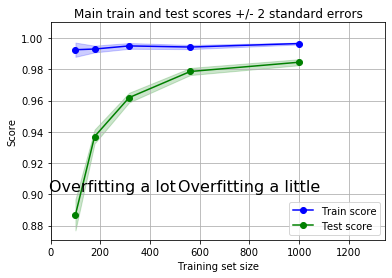

In [28]:
from scipy.stats import sem
# sem : standard error of the mean

mean_train = np.mean(train_scores, axis=1)
confidence = sem(train_scores, axis=1) * 2

plt.fill_between(train_sizes,
                 mean_train - confidence,
                 mean_train + confidence,
                 color = 'b', alpha = .2)
plt.plot(train_sizes, mean_train, 'o-k', c='b', label='Train score')

mean_test = np.mean(test_scores, axis=1)
confidence = sem(test_scores, axis=1) * 2

plt.fill_between(train_sizes,
                 mean_test - confidence,
                 mean_test + confidence,
                 color = 'g', alpha = .2)
plt.plot(train_sizes, mean_test, 'o-k', c='g', label='Test score')

plt.xlabel('Training set size')
plt.ylabel('Score')
plt.xlim(0, X_train.shape[0])
plt.ylim((None, 1.01))  # The best possible score is 1.0
plt.legend(loc='best')

plt.text(250, 0.9, "Overfitting a lot", fontsize=16, ha='center', va='bottom')
plt.text(800, 0.9, "Overfitting a little", fontsize=16, ha='center', va='bottom')
plt.title('Main train and test scores +/- 2 standard errors');

In [29]:
sem(train_scores, axis=1) * 2


array([0.00455955, 0.0021494 , 0.00185947, 0.00133842, 0.00058893])